# New York City Crash Report 
## Group E (NYC Crashers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import requests
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Reading and Assessment of Data 

In [2]:
df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', encoding='latin1')
df.info()

C:\Users\kiran\AppData\Local\Temp\ipykernel_1752\3975778814.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', encoding='latin1')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069364 entries, 0 to 2069363
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [3]:
df.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,1.836091e+06,1.836091e+06,2.069346e+06,2.069333e+06,2.069364e+06,2.069364e+06,2.069364e+06,2.069364e+06,2.069364e+06,2.069364e+06,2.069364e+06
mean,4.062767e+01,-7.375209e+01,3.091155e-01,1.488886e-03,5.641588e-02,7.393576e-04,2.674348e-02,1.145279e-04,2.223630e-01,6.117822e-04,3.155088e+06
std,1.981001e+00,3.724346e+00,6.995259e-01,4.070347e-02,2.438347e-01,2.765694e-02,1.633362e-01,1.074623e-02,6.606356e-01,2.707739e-02,1.505012e+06
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01
25%,4.066782e+01,-7.397485e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.153461e+06
50%,4.072084e+01,-7.392727e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.670920e+06
75%,4.076960e+01,-7.386673e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.188505e+06
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.706143e+06


In [4]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
CRASH DATE,09/11/2021,03/26/2022,06/29/2022,09/11/2021,12/14/2021,04/14/2021,12/14/2021,12/14/2021,12/14/2021,12/14/2021
CRASH TIME,2:39,11:45,6:55,9:35,8:13,12:47,17:05,8:17,21:10,14:58
BOROUGH,NaN,NaN,NaN,BROOKLYN,BROOKLYN,NaN,NaN,BRONX,BROOKLYN,MANHATTAN
ZIP CODE,NaN,NaN,NaN,11208.0,11233.0,NaN,NaN,10475.0,11207.0,10017.0
LATITUDE,NaN,NaN,NaN,40.667202,40.683304,NaN,40.709183,40.86816,40.67172,40.75144
LONGITUDE,NaN,NaN,NaN,-73.8665,-73.917274,NaN,-73.956825,-73.83148,-73.8971,-73.97397
LOCATION,NaN,NaN,NaN,"(40.667202, -73.8665)","(40.683304, -73.917274)",NaN,"(40.709183, -73.956825)","(40.86816, -73.83148)","(40.67172, -73.8971)","(40.75144, -73.97397)"
ON STREET NAME,WHITESTONE EXPRESSWAY,QUEENSBORO BRIDGE UPPER,THROGS NECK BRIDGE,NaN,SARATOGA AVENUE,MAJOR DEEGAN EXPRESSWAY RAMP,BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,3 AVENUE
CROSS STREET NAME,20 AVENUE,NaN,NaN,NaN,DECATUR STREET,NaN,NaN,NaN,NaN,EAST 43 STREET
OFF STREET NAME,NaN,NaN,NaN,1211 LORING AVENUE,NaN,NaN,NaN,344 BAYCHESTER AVENUE,2047 PITKIN AVENUE,NaN


* Assessment of the data's top values

In [5]:
df["CONTRIBUTING FACTOR VEHICLE 1"].value_counts()

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                       705280
Driver Inattention/Distraction    413784
Failure to Yield Right-of-Way     122835
Following Too Closely             110541
Backing Unsafely                   76540
                                   ...  
Windshield Inadequate                 80
Cell Phone (hand-held)                79
Texting                               51
Listening/Using Headphones            24
1                                     10
Name: count, Length: 61, dtype: int64

In [6]:
for i in range(1,6):
    df_cfv = df["CONTRIBUTING FACTOR VEHICLE "+str(i)].value_counts()
    print(f"===================== Contributing factor {i} =============================")
    print(df_cfv)

===================== Contributing factor 1 =============================
CONTRIBUTING FACTOR VEHICLE 1
Unspecified                       705280
Driver Inattention/Distraction    413784
Failure to Yield Right-of-Way     122835
Following Too Closely             110541
Backing Unsafely                   76540
                                   ...  
Windshield Inadequate                 80
Cell Phone (hand-held)                79
Texting                               51
Listening/Using Headphones            24
1                                     10
Name: count, Length: 61, dtype: int64
===================== Contributing factor 2 =============================
CONTRIBUTING FACTOR VEHICLE 2
Unspecified                       1472581
Driver Inattention/Distraction      93998
Other Vehicular                     31985
Following Too Closely               18963
Failure to Yield Right-of-Way       17078
                                   ...   
Eating or Drinking                     11
Listening

In [7]:
df.isnull().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           643847
ZIP CODE                          644097
LATITUDE                          233273
LONGITUDE                         233273
LOCATION                          233273
ON STREET NAME                    438882
CROSS STREET NAME                 781348
OFF STREET NAME                  1722855
NUMBER OF PERSONS INJURED             18
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6758
CONTRIBUTING FACTOR VEHICLE 2     320278
CONTRIBUTING FACTOR VEHICLE 3    1921629
CONTRIBUTING FACTOR VEHICLE 4    2036037
CONTRIBUTING FACTOR VEHICLE 5    2060344
COLLISION_ID                           0
VEHICLE TYPE COD

Seeeing as Columns CONTRIBUTING FACTOR VEHICLE 3-5 and VEHICLE TYPE CODE 3-5 are columns that are mostly empty we can drop these columns and focus on the main data in order to furhter our analysis.

In [8]:
df.drop(['CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5'],axis=1,inplace=True)
df.drop(['VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5'],axis=1,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069364 entries, 0 to 2069363
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [9]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

In [10]:
v_type1 = df['VEHICLE TYPE CODE 1'].value_counts()

In [11]:
v_type2 = df['VEHICLE TYPE CODE 2'].value_counts()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sedan'),
  Text(1, 0, 'Station Wagon/Sport Utility Vehicle'),
  Text(2, 0, 'PASSENGER VEHICLE'),
  Text(3, 0, 'SPORT UTILITY / STATION WAGON'),
  Text(4, 0, 'Taxi'),
  Text(5, 0, '4 dr sedan'),
  Text(6, 0, 'Pick-up Truck'),
  Text(7, 0, 'TAXI'),
  Text(8, 0, 'VAN'),
  Text(9, 0, 'Box Truck')])

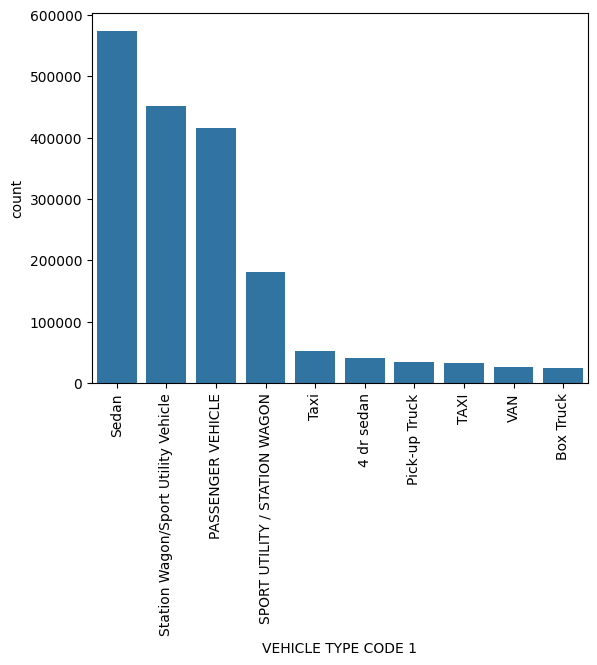

In [12]:
sns.barplot(v_type1[0:10])
plt.xticks(rotation=90)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sedan'),
  Text(1, 0, 'Station Wagon/Sport Utility Vehicle'),
  Text(2, 0, 'PASSENGER VEHICLE'),
  Text(3, 0, 'SPORT UTILITY / STATION WAGON'),
  Text(4, 0, 'UNKNOWN'),
  Text(5, 0, 'Taxi'),
  Text(6, 0, 'Bike'),
  Text(7, 0, 'Pick-up Truck'),
  Text(8, 0, '4 dr sedan'),
  Text(9, 0, 'Box Truck')])

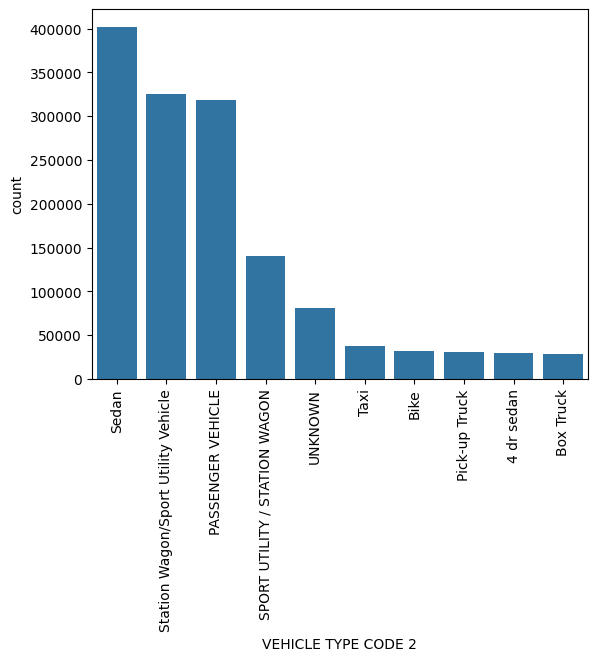

In [13]:
sns.barplot(v_type2[0:10])
plt.xticks(rotation=90)

The API application that is proposed will most likely be built using a K-Means clustering algorithm so in this case the best feature to use would be the longitude and latitude features. However some coordinates are missing so if the street names are provided for those missing rows, the values can be obtained using the OpenStreetMap Nominatim  API.

In [14]:
df_no_locs = df[df['LOCATION'].isna()]
df_street_names = df_no_locs[df_no_locs['ON STREET NAME'].notna()].shape

From the column above there are 177173 columns where the street name is known but not the location so we can input this data into the OpenStreetMap Nominatim API and get the approximate coordinates of the accidents. Since the dataset is soo large the other rows where the data is not known can simply be dropped as it may not have a ssignificant effect on the outcome of the analysis.

In [15]:
'''
addresses = list(df_street_names['ON STREET NAME'])
locations = []
for address in addresses:
    base_url = 'https://nominatim.openstreetmap.org/search'
    params = {'q': address, 'format': 'json'}
    response = requests.get(base_url, params=params)
    data = response.json()

    if data:
        lat = float(data[0]['lat'])
        lon = float(data[0]['lon'])
        locations = [lat,lon]
    else:
        print("Error receiving coordinates")
'''

'\naddresses = list(df_street_names[\'ON STREET NAME\'])\nlocations = []\nfor address in addresses:\n    base_url = \'https://nominatim.openstreetmap.org/search\'\n    params = {\'q\': address, \'format\': \'json\'}\n    response = requests.get(base_url, params=params)\n    data = response.json()\n\n    if data:\n        lat = float(data[0][\'lat\'])\n        lon = float(data[0][\'lon\'])\n        locations = [lat,lon]\n    else:\n        print("Error receiving coordinates")\n'

In [16]:
df['NUM PERSONS AFFECTED'] = df['NUMBER OF PERSONS INJURED'] + df['NUMBER OF PERSONS KILLED']

In [17]:
reg_df = df[['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','LOCATION','LONGITUDE','LATITUDE']]
reg_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUM PERSONS AFFECTED,LOCATION,LONGITUDE,LATITUDE
0,2021-09-11,2:39,NaN,2.0,0.0,2.0,NaN,NaN,NaN
1,2022-03-26,11:45,NaN,1.0,0.0,1.0,NaN,NaN,NaN
2,2022-06-29,6:55,NaN,0.0,0.0,0.0,NaN,NaN,NaN
3,2021-09-11,9:35,BROOKLYN,0.0,0.0,0.0,"(40.667202, -73.8665)",-73.866500,40.667202
4,2021-12-14,8:13,BROOKLYN,0.0,0.0,0.0,"(40.683304, -73.917274)",-73.917274,40.683304


In [18]:
reg_df['BOROUGH'].unique()

array([nan, 'BROOKLYN', 'BRONX', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [19]:
reg_df['Month'] = reg_df['CRASH DATE'].dt.month
reg_df['Year'] = reg_df['CRASH DATE'].dt.year
reg_df['month_year'] = reg_df['CRASH DATE'].dt.to_period('M')
reg_df['month_year'] = reg_df['month_year'].astype(str)
reg_df['month_year'] = pd.to_datetime(reg_df['month_year'])

C:\Users\kiran\AppData\Local\Temp\ipykernel_1752\2203625550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['Month'] = reg_df['CRASH DATE'].dt.month
C:\Users\kiran\AppData\Local\Temp\ipykernel_1752\2203625550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['Year'] = reg_df['CRASH DATE'].dt.year
C:\Users\kiran\AppData\Local\Temp\ipykernel_1752\2203625550.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [20]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069364 entries, 0 to 2069363
Data columns (total 12 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   CRASH DATE                 datetime64[ns]
 1   CRASH TIME                 object        
 2   BOROUGH                    object        
 3   NUMBER OF PERSONS INJURED  float64       
 4   NUMBER OF PERSONS KILLED   float64       
 5   NUM PERSONS AFFECTED       float64       
 6   LOCATION                   object        
 7   LONGITUDE                  float64       
 8   LATITUDE                   float64       
 9   Month                      int32         
 10  Year                       int32         
 11  month_year                 datetime64[ns]
dtypes: datetime64[ns](2), float64(5), int32(2), object(3)
memory usage: 173.7+ MB


In [21]:
reg_df_2 = reg_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']]
reg_df_2 = reg_df_2.groupby('month_year').sum()
reg_df_2.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUM PERSONS AFFECTED
month_year,,,
2012-07-01,4855.0,22.0,4877.0
2012-08-01,4751.0,27.0,4778.0
2012-09-01,4689.0,26.0,4715.0
2012-10-01,4572.0,21.0,4593.0
2012-11-01,3995.0,14.0,4009.0


In [22]:
reg_df_2['num_injured(thousands)'] = reg_df_2['NUMBER OF PERSONS INJURED']/1000
reg_df_2['num_killed(tens)'] = reg_df_2['NUMBER OF PERSONS KILLED']/10
reg_df_2['num_affected(thousands)'] = reg_df_2['NUM PERSONS AFFECTED']/1000
reg_df_2 = reg_df_2.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)
reg_df_2.head()

,num_injured(thousands),num_killed(tens),num_affected(thousands)
month_year,,,
2012-07-01,4.855,2.2,4.877
2012-08-01,4.751,2.7,4.778
2012-09-01,4.689,2.6,4.715
2012-10-01,4.572,2.1,4.593
2012-11-01,3.995,1.4,4.009


Text(0.5, 1.0, 'Line Plot of the Number of Injured, Killed and Affected Persons')

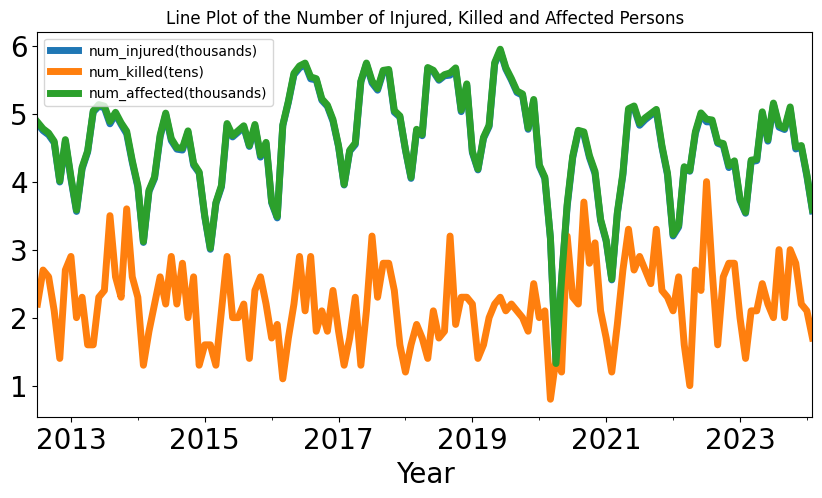

In [23]:
reg_df_2.plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.title("Line Plot of the Number of Injured, Killed and Affected Persons")

Text(0.5, 1.0, 'Line Plot of the Number of Affected Persons')

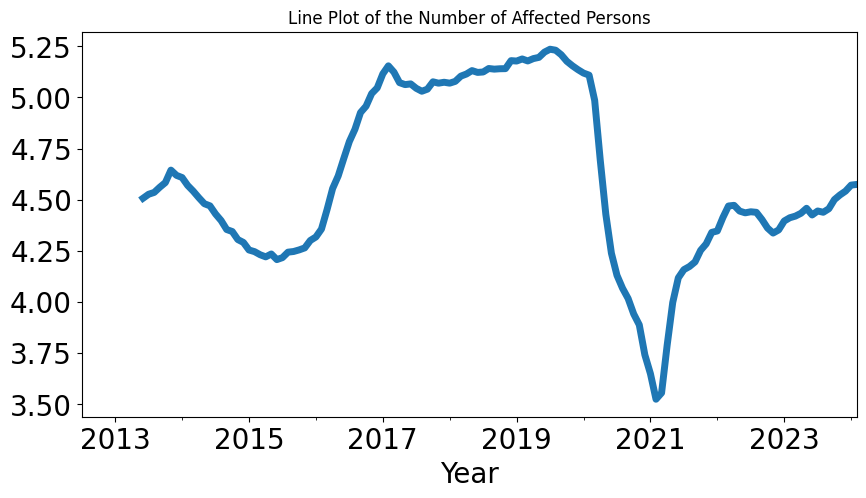

In [24]:
affected = reg_df_2['num_affected(thousands)'].copy()
affected.rolling(12).mean().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.title("Line Plot of the Number of Affected Persons")

Text(0.5, 0, 'Year')

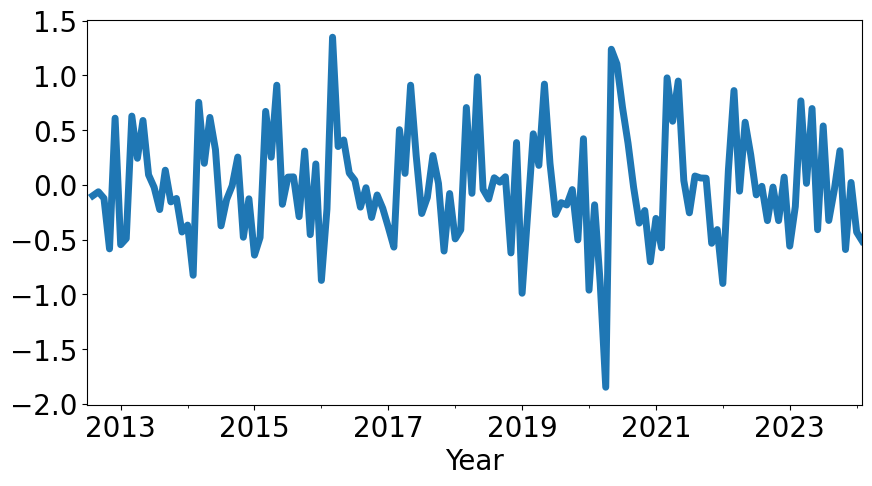

In [25]:
affected.diff().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

In [26]:
affected = reg_df_2[['num_affected(thousands)']].copy()
#affected['num_affected(thousands)'] = reg_df_2['num_affected(thousands)'].astype(np.float64)

In [27]:
affected

,num_affected(thousands)
month_year,
2012-07-01,4.877
2012-08-01,4.778
2012-09-01,4.715
2012-10-01,4.593
2012-11-01,4.009
...,...
2023-10-01,5.099
2023-11-01,4.509
2023-12-01,4.531


In [28]:
train = affected[affected.index.year < 2020]
test = affected[affected.index.year == 2023]

<h1>Naive Approach</h1>

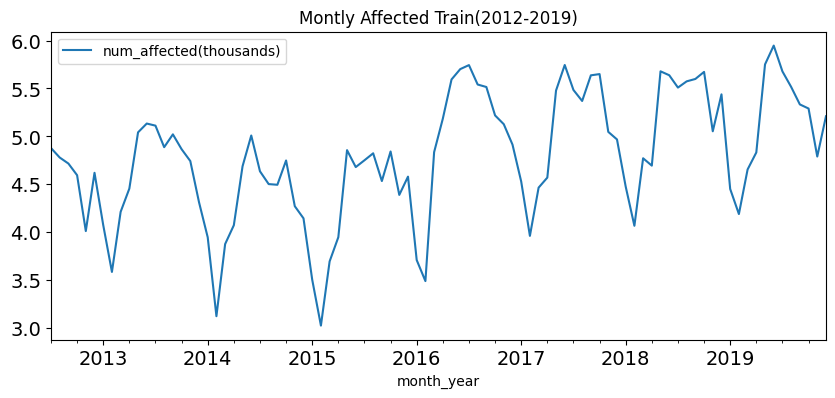

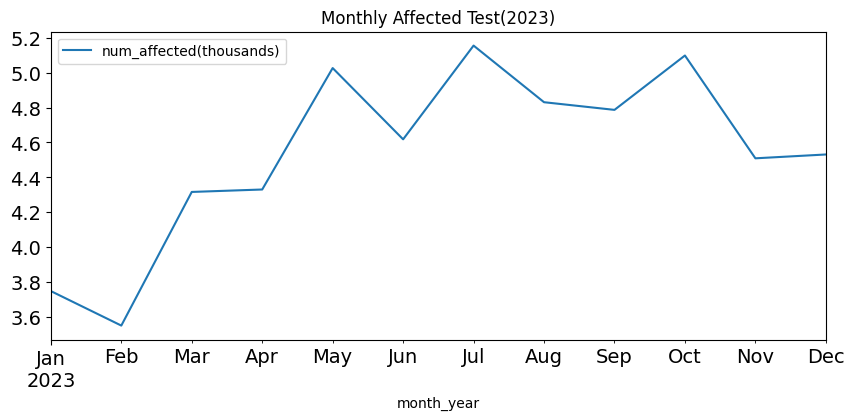

In [101]:
train.plot(figsize=(10,4), title= 'Montly Affected Train(2012-2019)', fontsize=14)
test.plot(figsize=(10,4), title= 'Monthly Affected Test(2023)', fontsize=14)
plt.show()

In [30]:
dd= np.asarray(train['num_affected(thousands)'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

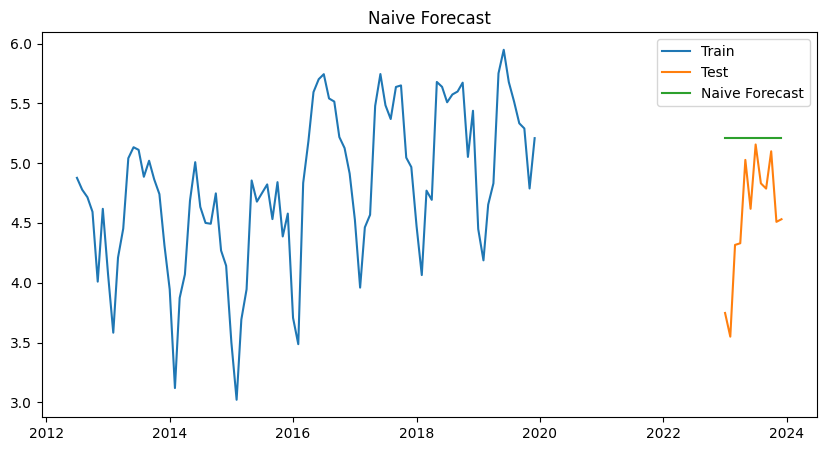

In [31]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index,test, label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [32]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat.naive))
print(rms)

0.8231595633087586


<h1>Simple Average</h1>

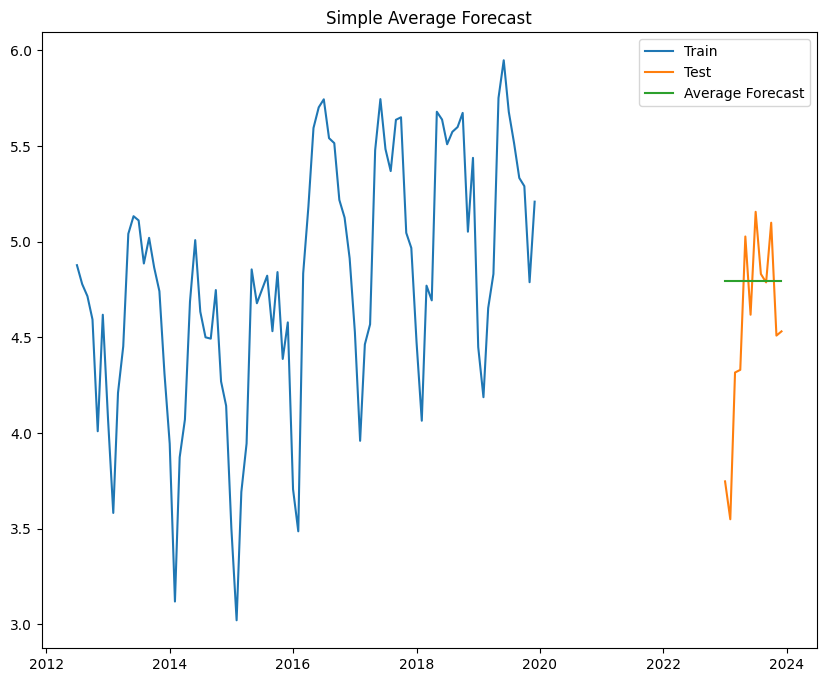

In [33]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['num_affected(thousands)'].mean()
plt.figure(figsize=(10,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.show()

In [34]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat_avg.avg_forecast))
print(rms)

0.5434440365522447


<h1>Moving Average Forecast</h1>

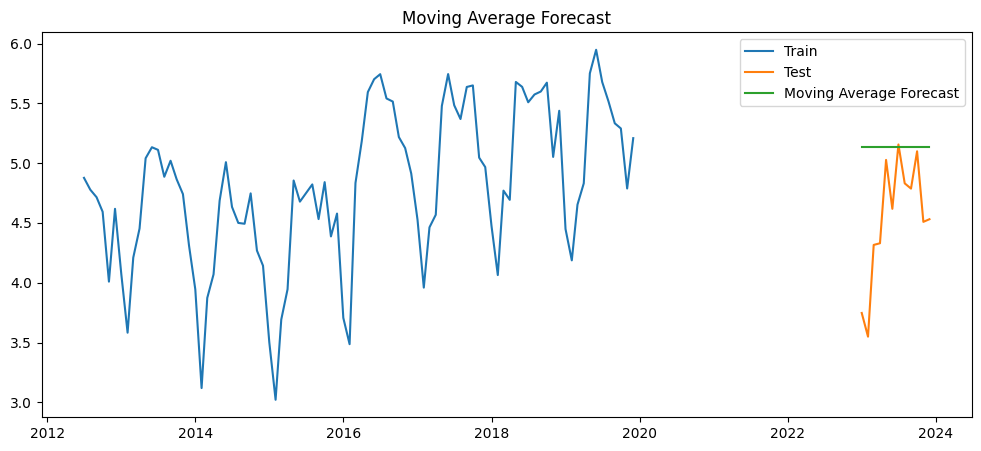

In [35]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['num_affected(thousands)'].rolling(12).mean().iloc[-1]
plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title("Moving Average Forecast")
plt.show()

In [36]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat_avg.moving_avg_forecast))
print(rms)

0.7652379123514466


Simple Exponential smoothing

num_affected(thousands)    5.230769
Name: 2019-12-01 00:00:00, dtype: float64 3.747
0.5944272248045729


C:\Users\kiran\AppData\Local\Temp\ipykernel_1752\2329415043.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(ft, test['num_affected(thousands)'][0])
C:\Users\kiran\AppData\Local\Temp\ipykernel_1752\2329415043.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dt = test['num_affected(thousands)'][i-1]
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)
c:\Us

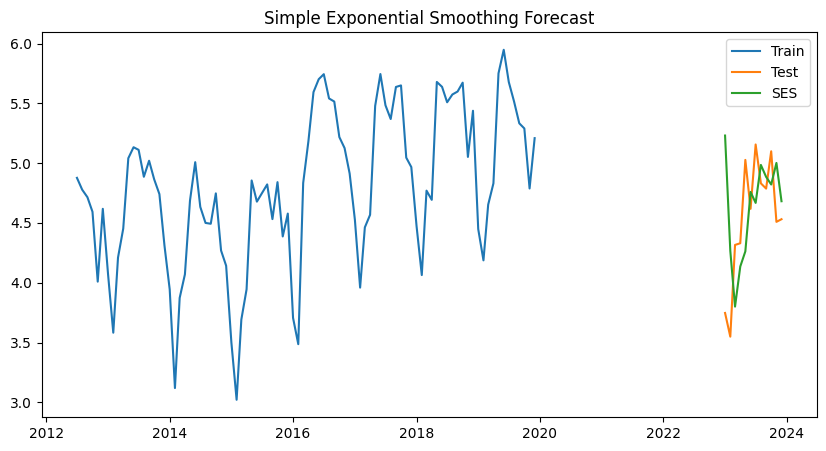

In [37]:
y_hat_avg = test.copy()

pred = []
#s = 9
a = 0.65
#a = 2/(s+1)
#ft = pd.DataFrame.ewm(train, alpha = a).mean()['gym'][-1]
ft = pd.DataFrame.ewm(train, span = 10).mean().iloc[-1]
#ft = train['gym'].mean()
pred.append(ft)
print(ft, test['num_affected(thousands)'][0])
for i in range(1,len(test['num_affected(thousands)'])):
    dt = test['num_affected(thousands)'][i-1]
    ft_plus_1 = a*dt + (1-a)*ft
    #print(i, dt, ft, ft_plus_1)
    pred.append(ft_plus_1)
    ft = ft_plus_1
y_hat_avg['SES'] = pd.Series(pred).values

rms = np.sqrt(mean_squared_error(test, y_hat_avg.SES))
print(rms)

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.title("Simple Exponential Smoothing Forecast")
plt.show()

In [38]:
rms = np.sqrt(mean_squared_error(test['num_affected(thousands)'], y_hat_avg.SES))
print(rms)

0.5944272248045729


c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_array_api.py:521: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


ARIMA Model

In [39]:
from statsmodels.graphics.tsaplots import plot_acf

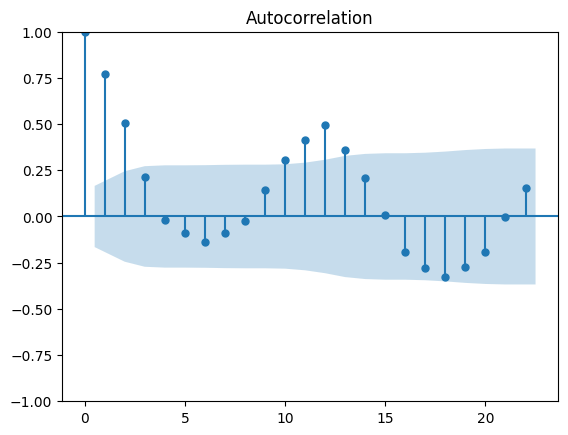

In [40]:
plot_acf(reg_df_2['num_affected(thousands)']);

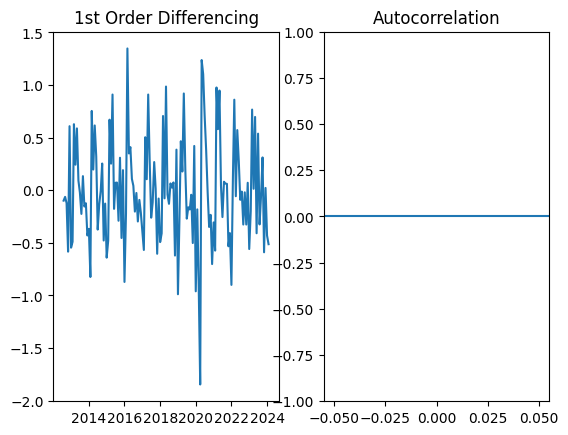

In [41]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(reg_df_2['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(reg_df_2['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

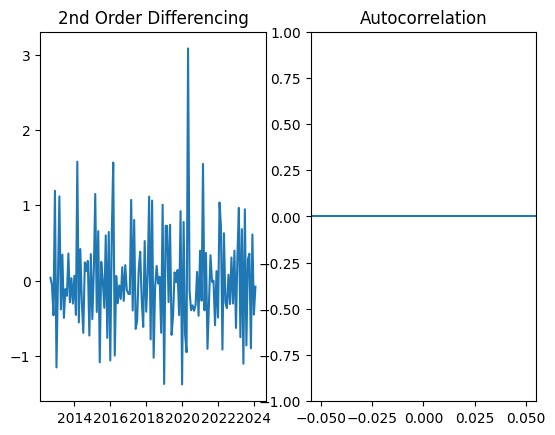

In [42]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(reg_df_2['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(reg_df_2['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller

In [44]:
result = adfuller(reg_df_2['num_affected(thousands)'])
print(f"p value: {result[1]}")

#result = adfuller(reg_df_2['num_affected(thousands)'].diff())
#print(f"p value: {result[1]}")

#result = adfuller(reg_df_2['num_affected(thousands)'].diff().diff())
#print(f"p value: {result[1]}")

p value: 0.3123484108136313


It appears that you cant find the difference of this dataset hence we will plot the ARIMA Model based on the original data

In [45]:
from statsmodels.tsa.arima.model import ARIMA

In [114]:
train2 = affected[affected.index.year != 2020]
#train2 = train2[affected.index.year != 2021]
#train2 = train2[affected.index.year != 2022]
ar_train = train2['num_affected(thousands)']

In [171]:
arima_model = ARIMA(reg_df_2['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary());

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     num_affected(thousands)   No. Observations:                  140
Model:                      ARIMA(1, 1, 3)   Log Likelihood                 -87.907
Date:                     Fri, 19 Apr 2024   AIC                            185.814
Time:                             09:34:59   BIC                            200.487
Sample:                         07-01-2012   HQIC                           191.777
                              - 02-01-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5950      0.099      6.025      0.000       0.401       0.789
ma.L1         -0.7589      0.927     -0.818      0.413      -2.577       1.059
ma.L2       

Text(0.5, 1.0, 'Plot of the ARIMA Forecasting')

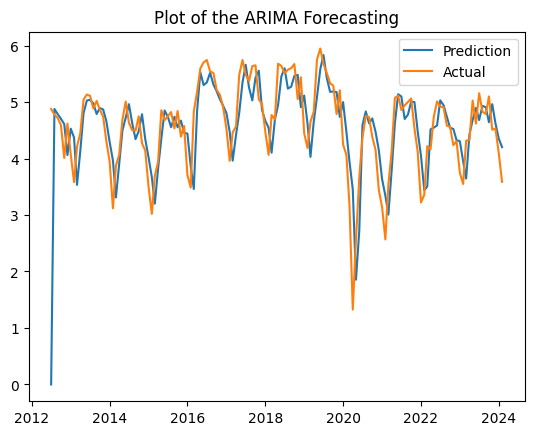

In [172]:
plt.plot(model.predict(dynamic=False))
plt.plot(reg_df_2['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Plot of the ARIMA Forecasting")

In [116]:
rms = np.sqrt(mean_squared_error(reg_df_2['num_affected(thousands)'], model.predict(dynamic=False)))
print(rms)

0.6123005682491086


Text(0.5, 1.0, 'Predicted forecast for 2024')

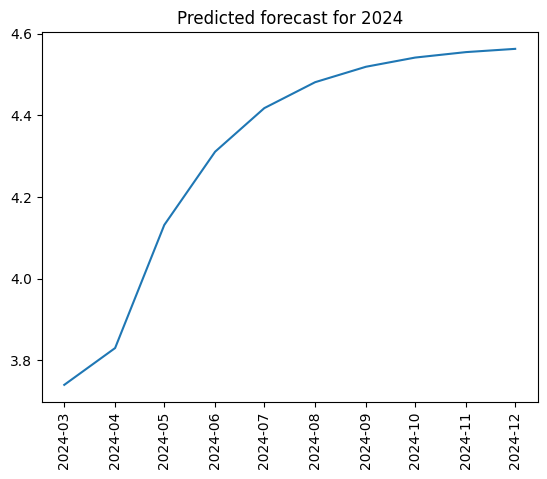

In [173]:
plt.plot(model.forecast(10,True))
plt.xticks(rotation=90)
plt.title("Predicted forecast for 2024")

In [118]:
reg_df_2['num_affected(thousands)'][reg_df_2.index == "2023-12-01"]

month_year
2023-12-01    4.531
Name: num_affected(thousands), dtype: float64

In [119]:
model.forecast(10,True)

2024-03-01    3.739379
2024-04-01    3.829548
2024-05-01    4.131271
2024-06-01    4.310807
2024-07-01    4.417637
2024-08-01    4.481205
2024-09-01    4.519030
2024-10-01    4.541537
2024-11-01    4.554929
2024-12-01    4.562898
Freq: MS, Name: predicted_mean, dtype: float64

TIME SERIES BY BOROUGH

In [120]:
reg_df_3 = reg_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year','BOROUGH','LOCATION','LONGITUDE','LATITUDE']]
reg_df_3.head()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUM PERSONS AFFECTED,month_year,BOROUGH,LOCATION,LONGITUDE,LATITUDE
0,2.0,0.0,2.0,2021-09-01,NaN,NaN,NaN,NaN
1,1.0,0.0,1.0,2022-03-01,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,2022-06-01,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,2021-09-01,BROOKLYN,"(40.667202, -73.8665)",-73.866500,40.667202
4,0.0,0.0,0.0,2021-12-01,BROOKLYN,"(40.683304, -73.917274)",-73.917274,40.683304


In [121]:
print(reg_df_3.isna().sum())
print(reg_df_3.shape)

NUMBER OF PERSONS INJURED        18
NUMBER OF PERSONS KILLED         31
NUM PERSONS AFFECTED             37
month_year                        0
BOROUGH                      643847
LOCATION                     233273
LONGITUDE                    233273
LATITUDE                     233273
dtype: int64
(2069364, 8)


In [122]:
reg_df_3 = reg_df_3.dropna()
reg_df_3.isnull().sum()

NUMBER OF PERSONS INJURED    0
NUMBER OF PERSONS KILLED     0
NUM PERSONS AFFECTED         0
month_year                   0
BOROUGH                      0
LOCATION                     0
LONGITUDE                    0
LATITUDE                     0
dtype: int64

In [123]:
#unusable = reg_df_3[reg_df_3['LOCATION'].isnull() & reg_df_3['BOROUGH'].isnull()].index
#reg_df_3 = reg_df_3.drop(unusable)
#reg_df_3

In [124]:
reg_df_3_NB = reg_df_3[reg_df_3['BOROUGH'].isnull()]
reg_df_3_NB

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUM PERSONS AFFECTED,month_year,BOROUGH,LOCATION,LONGITUDE,LATITUDE


In [125]:
from geopy.distance import geodesic

# Define the coordinates for the boundaries of each NYC borough
borough_boundaries = {
    'Manhattan': [(40.698457, -74.019327), (40.872023, -73.910044)],
    'Brooklyn': [(40.570842, -74.042787), (40.739446, -73.833365)],
    'Queens': [(40.477399, -73.866095), (40.806807, -73.700272)],
    'Bronx': [(40.785881, -73.933510), (40.917533, -73.765206)],
    'Staten Island': [(40.477199, -74.259090), (40.651278, -74.034278)]
}

In [126]:
def get_borough_from_coords(latitude, longitude):
    point = (latitude, longitude)
    for borough, boundaries in borough_boundaries.items():
        if boundaries[0][0] <= latitude <= boundaries[1][0] and boundaries[0][1] <= longitude <= boundaries[1][1]:
            return borough
    return 'Unknown'

def add_borough_column(df):
    df['Borough'] = df.apply(lambda row: get_borough_from_coords(row['LATITUDE'], row['LONGITUDE']), axis=1)
    return df

In [127]:
#reg_df_bor_added = add_borough_column(df[['LONGITUDE','LATITUDE']])
#reg_df_bor_added

In [128]:
df['BOROUGH'].unique()

array([nan, 'BROOKLYN', 'BRONX', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
      dtype=object)

In [129]:
brook_df = reg_df_3[reg_df_3['BOROUGH'] == 'BROOKLYN']
brook_df = brook_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()

queen_df = reg_df_3[reg_df_3['BOROUGH'] == 'QUEENS']
queen_df = queen_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


bronx_df = reg_df_3[reg_df_3['BOROUGH'] == 'BRONX']
bronx_df = bronx_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


man_df = reg_df_3[reg_df_3['BOROUGH'] == 'MANHATTAN']
man_df = man_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


statIsl_df = reg_df_3[reg_df_3['BOROUGH'] == 'STATEN ISLAND']
statIsl_df = statIsl_df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED','month_year']].groupby('month_year').sum()


In [130]:
brook_df['num_injured(thousands)'] = brook_df['NUMBER OF PERSONS INJURED']/1000
brook_df['num_killed(tens)'] = brook_df['NUMBER OF PERSONS KILLED']/10
brook_df['num_affected(thousands)'] = brook_df['NUM PERSONS AFFECTED']/1000
brook_df = brook_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

queen_df['num_injured(thousands)'] = queen_df['NUMBER OF PERSONS INJURED']/1000
queen_df['num_killed(tens)'] = queen_df['NUMBER OF PERSONS KILLED']/10
queen_df['num_affected(thousands)'] = queen_df['NUM PERSONS AFFECTED']/1000
queen_df = queen_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

bronx_df['num_injured(thousands)'] = bronx_df['NUMBER OF PERSONS INJURED']/1000
bronx_df['num_killed(tens)'] = bronx_df['NUMBER OF PERSONS KILLED']/10
bronx_df['num_affected(thousands)'] = bronx_df['NUM PERSONS AFFECTED']/1000
bronx_df = bronx_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

man_df['num_injured(thousands)'] = man_df['NUMBER OF PERSONS INJURED']/1000
man_df['num_killed(tens)'] = man_df['NUMBER OF PERSONS KILLED']/10
man_df['num_affected(thousands)'] = man_df['NUM PERSONS AFFECTED']/1000
man_df = man_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

statIsl_df['num_injured(thousands)'] = statIsl_df['NUMBER OF PERSONS INJURED']/1000
statIsl_df['num_killed(tens)'] = statIsl_df['NUMBER OF PERSONS KILLED']/10
statIsl_df['num_affected(thousands)'] = statIsl_df['NUM PERSONS AFFECTED']/1000
statIsl_df = statIsl_df.drop(['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUM PERSONS AFFECTED'],axis=1)

Text(0.5, 1.0, 'Affected Persons by Borough')

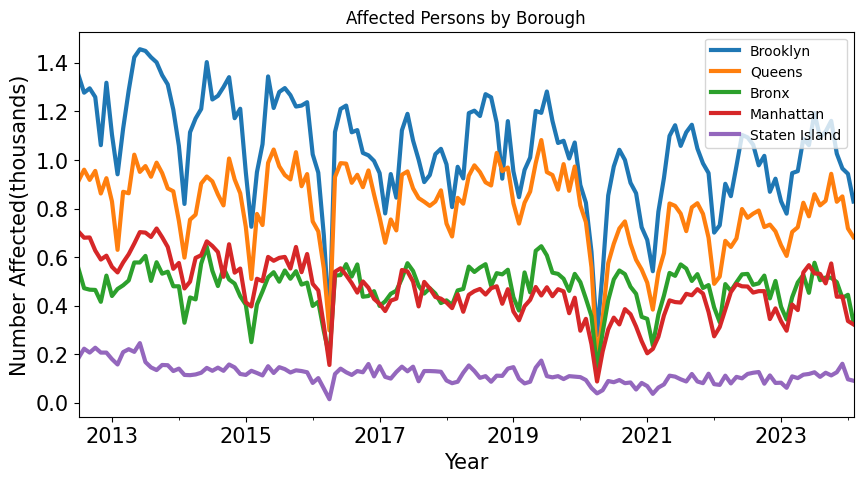

In [131]:
brook_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
queen_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
bronx_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
man_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
statIsl_df['num_affected(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.xlabel('Year', fontsize=15);
plt.ylabel('Number Affected(thousands)', fontsize=15);
plt.legend(('Brooklyn','Queens','Bronx','Manhattan','Staten Island'))
plt.title("Affected Persons by Borough")


Text(0.5, 1.0, 'Injured Persons by Borough')

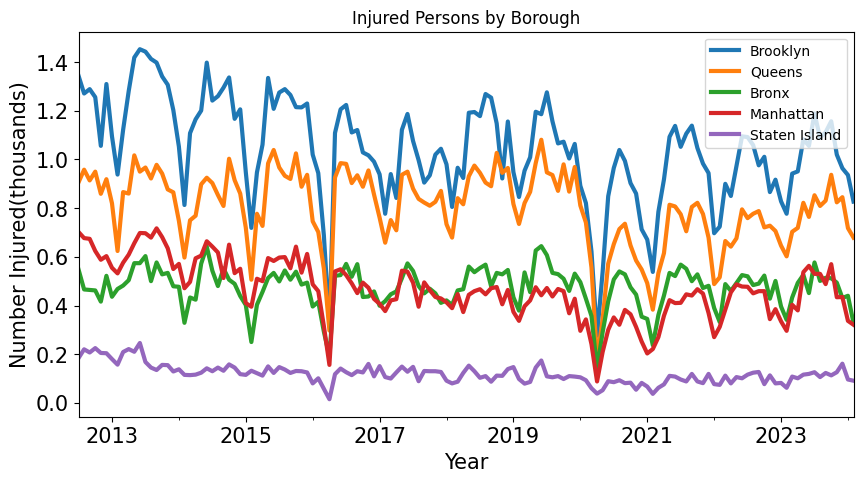

In [132]:
brook_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
queen_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
bronx_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
man_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
statIsl_df['num_injured(thousands)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.xlabel('Year', fontsize=15);
plt.ylabel('Number Injured(thousands)', fontsize=15);
plt.legend(('Brooklyn','Queens','Bronx','Manhattan','Staten Island'))
plt.title("Injured Persons by Borough")

Text(0.5, 1.0, 'Killed Persons by Borough')

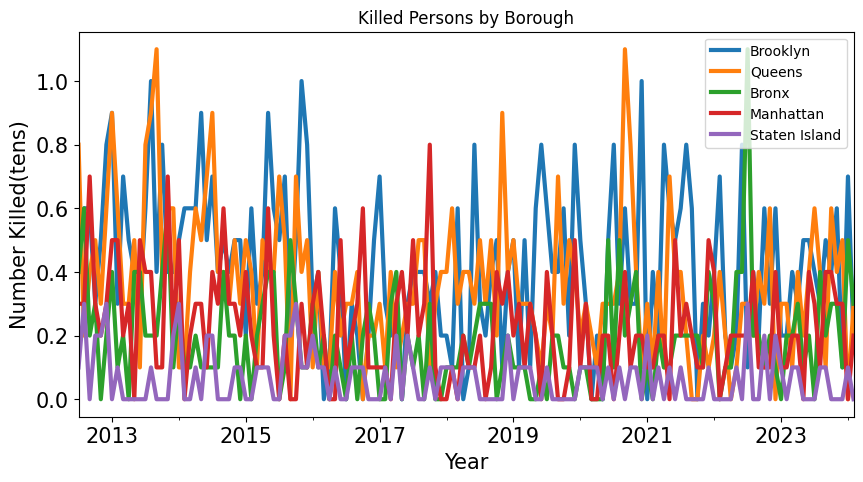

In [133]:
brook_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
queen_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
bronx_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
man_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
statIsl_df['num_killed(tens)'].plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.xlabel('Year', fontsize=15);
plt.ylabel('Number Killed(tens)', fontsize=15);
plt.legend(('Brooklyn','Queens','Bronx','Manhattan','Staten Island'))
plt.title("Killed Persons by Borough")

BROOKLYN ARIMA ANALYSIS

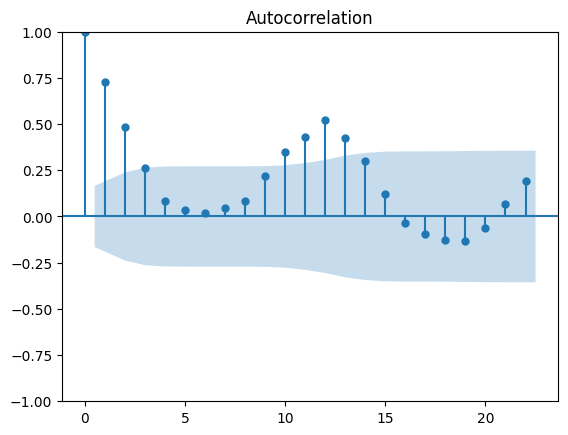

In [134]:
plot_acf(brook_df['num_affected(thousands)']);

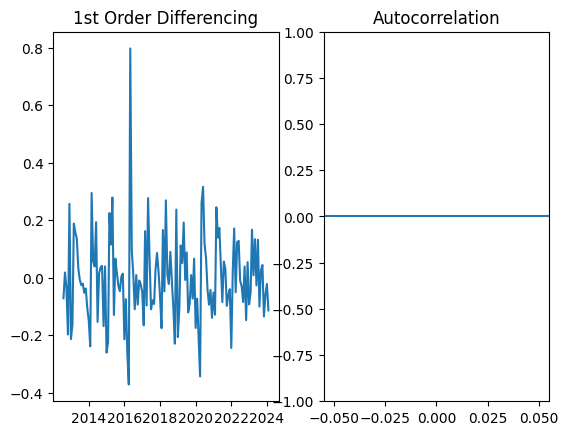

In [135]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(brook_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(brook_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

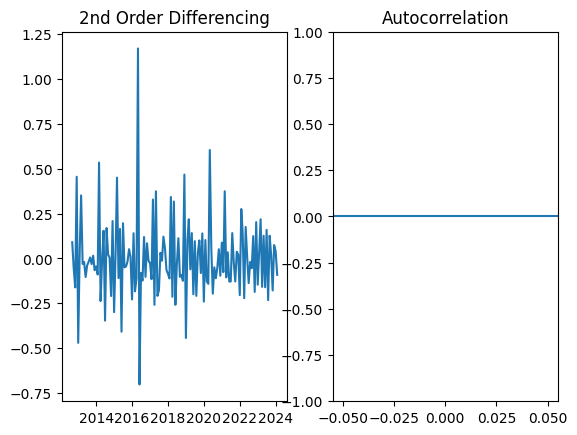

In [136]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(brook_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(brook_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [137]:
result = adfuller(brook_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

p value: 0.3262710058702659


In [175]:
arima_model = ARIMA(brook_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     num_affected(thousands)   No. Observations:                  140
Model:                      ARIMA(1, 1, 3)   Log Likelihood                  75.493
Date:                     Fri, 19 Apr 2024   AIC                           -140.986
Time:                             11:26:59   BIC                           -126.314
Sample:                         07-01-2012   HQIC                          -135.024
                              - 02-01-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5029      0.253      1.990      0.047       0.008       0.998
ma.L1         -0.7315      0.295     -2.480      0.013      -1.310      -0.153
ma.L2       

Text(0.5, 1.0, 'Predicted vs Actual Number of Affected in Brooklyn')

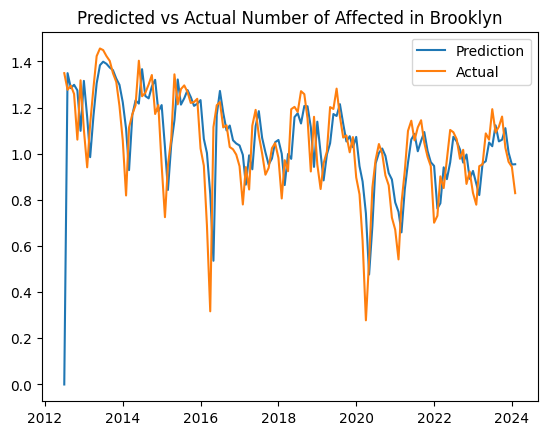

In [139]:
plt.plot(model.predict(dynamic=False))
plt.plot(brook_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Brooklyn")

Text(0.5, 1.0, 'Brooklyn Forecast')

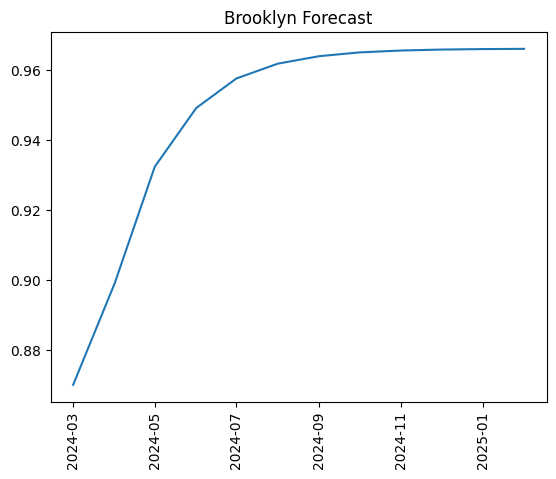

In [140]:
plt.plot(model.forecast(12,True));
plt.xticks(rotation=90);
plt.title("Brooklyn Forecast")

In [174]:
brook_df['num_affected(thousands)'][brook_df.index == "2023-12-01"]

month_year
2023-12-01    0.965
Name: num_affected(thousands), dtype: float64

In [176]:
model.forecast(10,True)

2024-03-01    0.869978
2024-04-01    0.898961
2024-05-01    0.932342
2024-06-01    0.949129
2024-07-01    0.957570
2024-08-01    0.961815
2024-09-01    0.963950
2024-10-01    0.965024
2024-11-01    0.965563
2024-12-01    0.965835
Freq: MS, Name: predicted_mean, dtype: float64

<h1>ARIMA Modelling for QUEENS</h1>

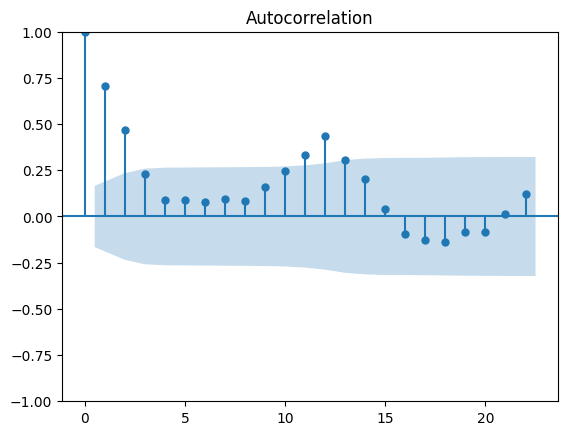

In [177]:
plot_acf(queen_df['num_affected(thousands)']);

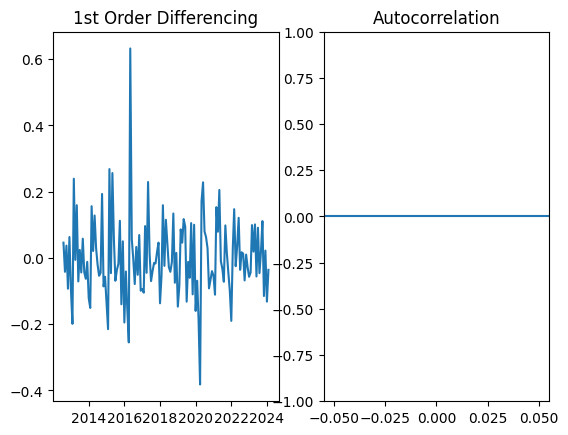

In [178]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(queen_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(queen_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

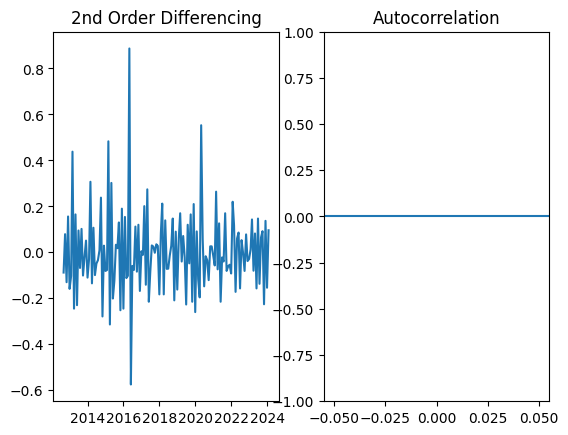

In [179]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(queen_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(queen_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [180]:
result = adfuller(queen_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

p value: 0.2970062406131165


In [181]:
arima_model = ARIMA(queen_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     num_affected(thousands)   No. Observations:                  140
Model:                      ARIMA(1, 1, 3)   Log Likelihood                 110.268
Date:                     Fri, 19 Apr 2024   AIC                           -210.535
Time:                             11:42:22   BIC                           -195.863
Sample:                         07-01-2012   HQIC                          -204.573
                              - 02-01-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4412      0.200      2.204      0.028       0.049       0.834
ma.L1         -0.7106      0.250     -2.846      0.004      -1.200      -0.221
ma.L2       

Text(0.5, 1.0, 'Predicted vs Actual Number of Affected in Queens')

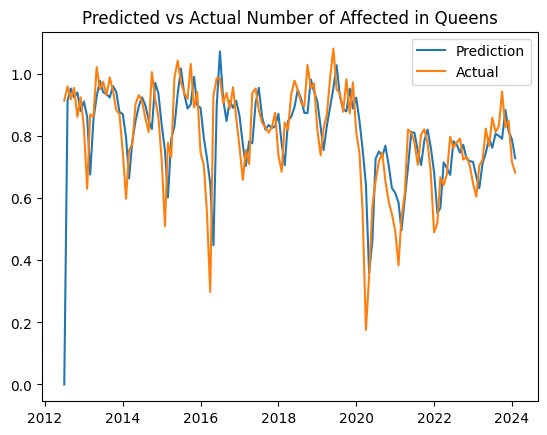

In [182]:
plt.plot(model.predict(dynamic=False))
plt.plot(queen_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Queens")

Text(0.5, 1.0, 'Queens Forecast')

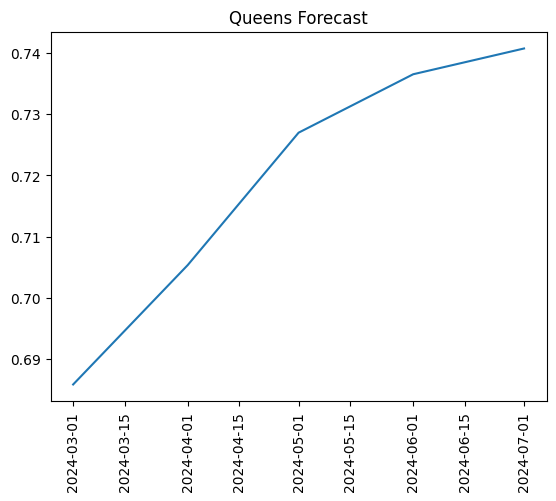

In [183]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)
plt.title("Queens Forecast")

In [184]:
queen_df['num_affected(thousands)'][queen_df.index == "2023-12-01"]

month_year
2023-12-01    0.85
Name: num_affected(thousands), dtype: float64

In [185]:
model.forecast(10,True)

2024-03-01    0.685807
2024-04-01    0.705339
2024-05-01    0.726999
2024-06-01    0.736556
2024-07-01    0.740773
2024-08-01    0.742634
2024-09-01    0.743455
2024-10-01    0.743817
2024-11-01    0.743977
2024-12-01    0.744048
Freq: MS, Name: predicted_mean, dtype: float64

<h1>ARIMA Modelling for Bronx</h1>

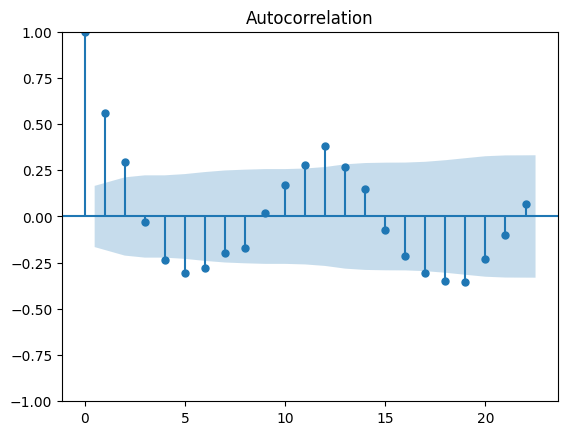

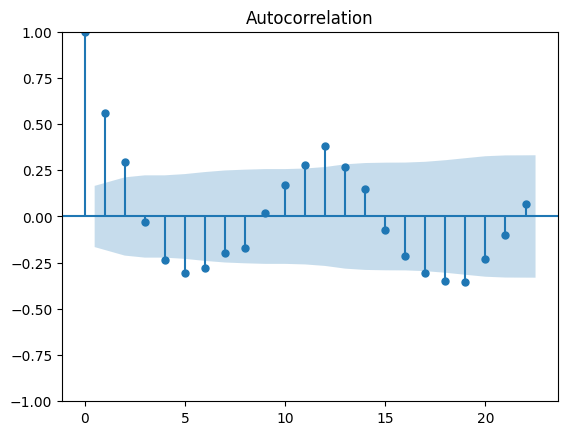

In [186]:
plot_acf(bronx_df['num_affected(thousands)'])

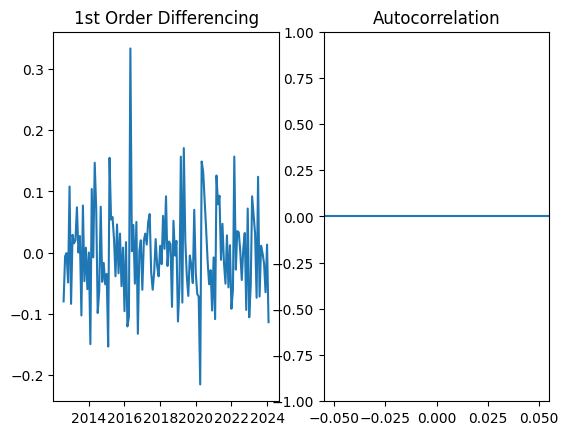

In [187]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(bronx_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(bronx_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

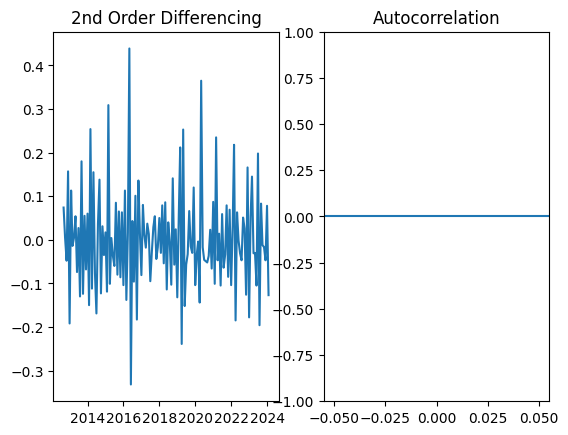

In [188]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(bronx_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(bronx_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [189]:
result = adfuller(bronx_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

p value: 5.942809599502534e-09


In [190]:
arima_model = ARIMA(bronx_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                  SARIMAX Results                                  
Dep. Variable:     num_affected(thousands)   No. Observations:                  140
Model:                      ARIMA(1, 1, 3)   Log Likelihood                 176.994
Date:                     Fri, 19 Apr 2024   AIC                           -343.987
Time:                             11:42:26   BIC                           -329.315
Sample:                         07-01-2012   HQIC                          -338.025
                              - 02-01-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4002      0.216      1.855      0.064      -0.023       0.823
ma.L1         -0.8288      1.160     -0.715      0.475      -3.101       1.444
ma.L2       

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'Predicted vs Actual Number of Affected in The Bronx')

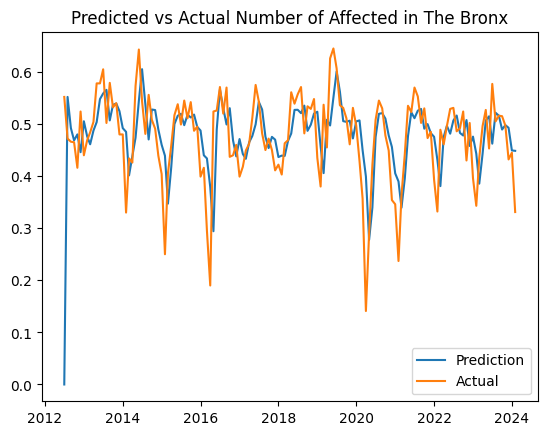

In [191]:
plt.plot(model.predict(dynamic=False))
plt.plot(bronx_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in The Bronx")

Text(0.5, 1.0, 'The Bronx Forecast')

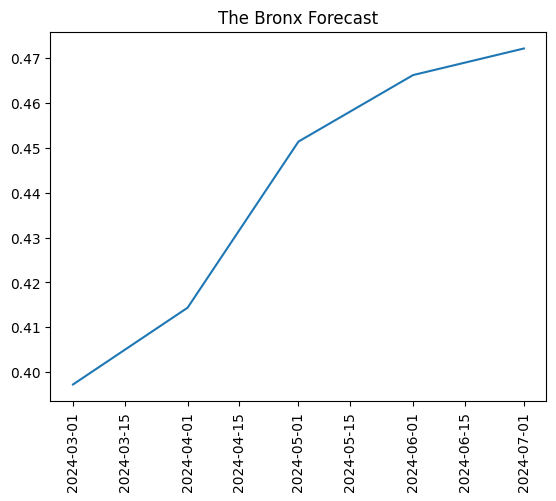

In [192]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)
plt.title("The Bronx Forecast")

In [193]:
bronx_df['num_affected(thousands)'][bronx_df.index == "2023-12-01"]

month_year
2023-12-01    0.432
Name: num_affected(thousands), dtype: float64

In [194]:
model.forecast(10,True)

2024-03-01    0.397249
2024-04-01    0.414366
2024-05-01    0.451413
2024-06-01    0.466237
2024-07-01    0.472169
2024-08-01    0.474543
2024-09-01    0.475493
2024-10-01    0.475873
2024-11-01    0.476025
2024-12-01    0.476086
Freq: MS, Name: predicted_mean, dtype: float64

<h1>ARIMA Modelling for Manhattan</h1>

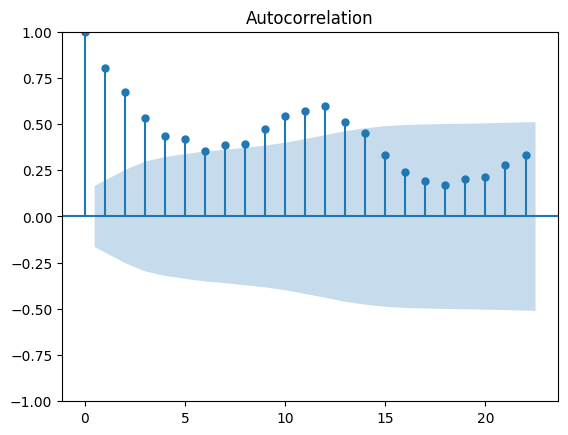

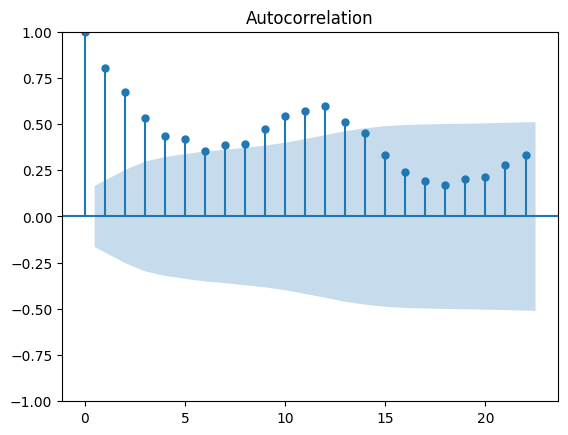

In [195]:
plot_acf(man_df['num_affected(thousands)'])

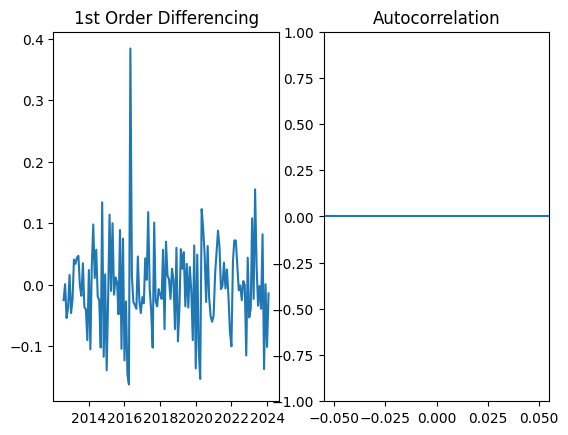

In [196]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(man_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(man_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

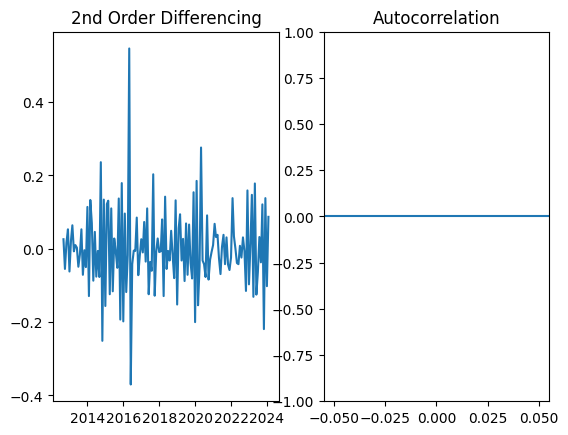

In [197]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(man_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(man_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [198]:
result = adfuller(man_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

p value: 0.3545217279522791


In [199]:
arima_model = ARIMA(man_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     num_affected(thousands)   No. Observations:                  140
Model:                      ARIMA(1, 1, 3)   Log Likelihood                 179.246
Date:                     Fri, 19 Apr 2024   AIC                           -348.492
Time:                             11:42:29   BIC                           -333.820
Sample:                         07-01-2012   HQIC                          -342.530
                              - 02-01-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4052      0.242      1.677      0.094      -0.068       0.879
ma.L1         -0.6963      0.263     -2.646      0.008      -1.212      -0.180
ma.L2       

Text(0.5, 1.0, 'Predicted vs Actual Number of Affected in Manhattan')

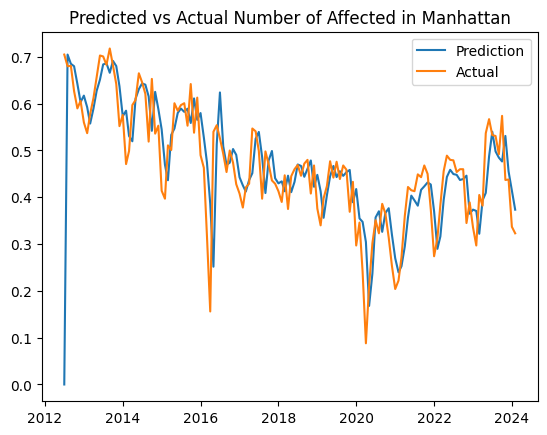

In [200]:
plt.plot(model.predict(dynamic=False))
plt.plot(man_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Manhattan")

Text(0.5, 1.0, 'Manhattan Forecast')

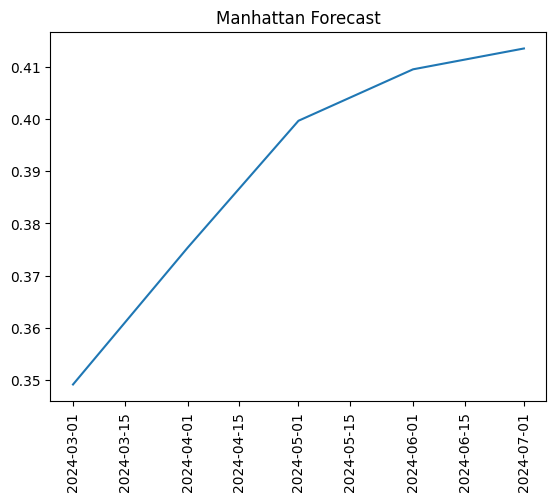

In [201]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)
plt.title("Manhattan Forecast")

In [202]:
man_df['num_affected(thousands)'][man_df.index == "2023-12-01"]

month_year
2023-12-01    0.438
Name: num_affected(thousands), dtype: float64

In [203]:
model.forecast(10,True)

2024-03-01    0.349114
2024-04-01    0.375335
2024-05-01    0.399681
2024-06-01    0.409546
2024-07-01    0.413542
2024-08-01    0.415162
2024-09-01    0.415818
2024-10-01    0.416084
2024-11-01    0.416191
2024-12-01    0.416235
Freq: MS, Name: predicted_mean, dtype: float64

<h1>ARIMA MODELLING FOR STATEN ISLAND</h1>

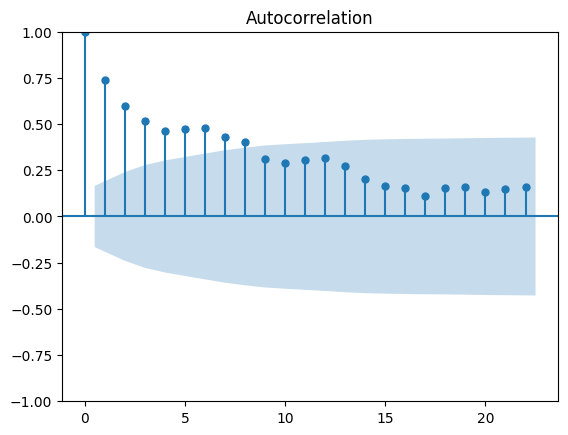

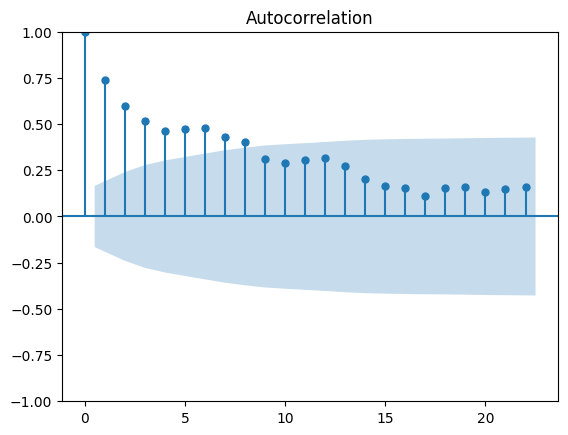

In [204]:
plot_acf(statIsl_df['num_affected(thousands)'])

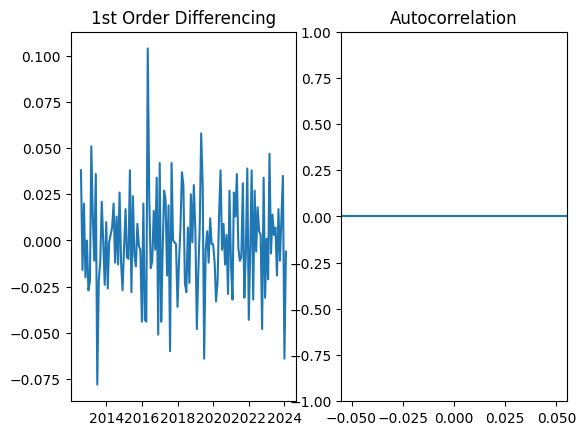

In [205]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(statIsl_df['num_affected(thousands)'].diff())

ax2 = f.add_subplot(122)
plot_acf(statIsl_df['num_affected(thousands)'].diff(), ax=ax2)
plt.show()

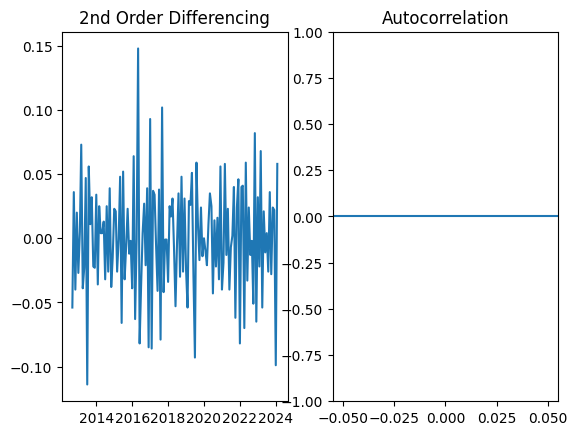

In [206]:
f = plt.figure()
ax1= f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(statIsl_df['num_affected(thousands)'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(statIsl_df['num_affected(thousands)'].diff().diff(), ax=ax2)
plt.show()

In [207]:
result = adfuller(statIsl_df['num_affected(thousands)'])
print(f"p value: {result[1]}")

p value: 0.00013486860225777347


In [208]:
arima_model = ARIMA(statIsl_df['num_affected(thousands)'],order=(1,1,3))
model = arima_model.fit()
print(model.summary())

c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\kiran\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                  SARIMAX Results                                  
Dep. Variable:     num_affected(thousands)   No. Observations:                  140
Model:                      ARIMA(1, 1, 3)   Log Likelihood                 316.873
Date:                     Fri, 19 Apr 2024   AIC                           -623.746
Time:                             11:42:33   BIC                           -609.074
Sample:                         07-01-2012   HQIC                          -617.784
                              - 02-01-2024                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1366      0.855      0.160      0.873      -1.539       1.812
ma.L1         -0.5768      0.852     -0.677      0.498      -2.246       1.093
ma.L2       

Text(0.5, 1.0, 'Predicted vs Actual Number of Affected in Staten Island')

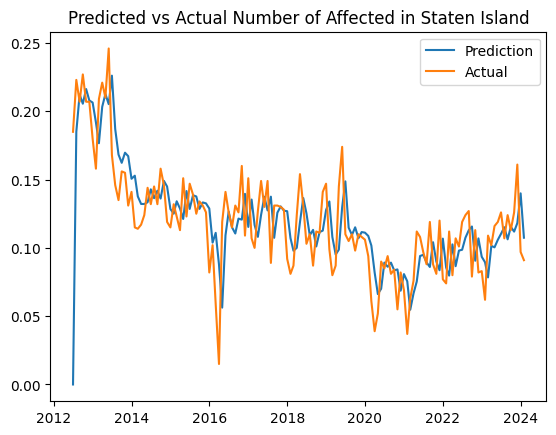

In [209]:
plt.plot(model.predict(dynamic=False))
plt.plot(statIsl_df['num_affected(thousands)'])
plt.legend(("Prediction","Actual"))
plt.title("Predicted vs Actual Number of Affected in Staten Island")

Text(0.5, 1.0, 'Staten Island Forecast')

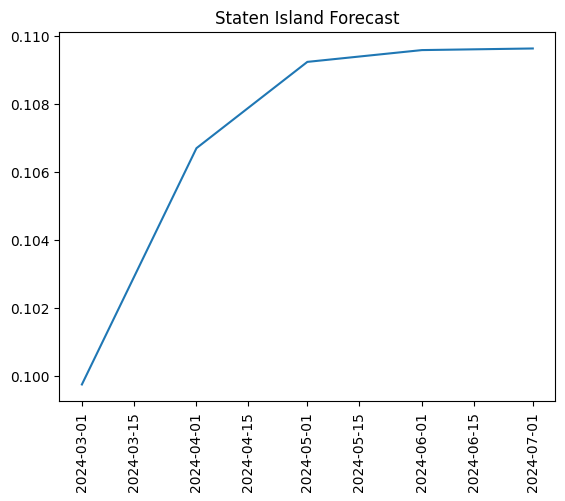

In [210]:
plt.plot(model.forecast(5,True))
plt.xticks(rotation=90)
plt.title("Staten Island Forecast")

In [211]:
statIsl_df['num_affected(thousands)'][statIsl_df.index == "2023-12-01"]

month_year
2023-12-01    0.161
Name: num_affected(thousands), dtype: float64

In [212]:
model.forecast(10,True)

2024-03-01    0.099748
2024-04-01    0.106699
2024-05-01    0.109238
2024-06-01    0.109585
2024-07-01    0.109632
2024-08-01    0.109639
2024-09-01    0.109640
2024-10-01    0.109640
2024-11-01    0.109640
2024-12-01    0.109640
Freq: MS, Name: predicted_mean, dtype: float64